1. Data Preparation

In [2]:
import tensorflow as tf 
from tensorflow.keras import datasets,layers,models

BATCH_SIZE = 100

def load_image(img_path,size = (32,32)):
    label = tf.constant(1,tf.int8) if tf.strings.regex_full_match(img_path,".*automobile.*") \
            else tf.constant(0,tf.int8)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img) #In jpeg format
    img = tf.image.resize(img,size)/255.0
    return(img,label)


2023-05-05 09:57:46.513711: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-05 09:57:47.434378: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
#Parallel pre-processing using num_parallel_calls and caching data with prefetch function to improve the performance
ds_train = tf.data.Dataset.list_files("./data/cifar2/train/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .shuffle(buffer_size = 1000).batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)  

ds_test = tf.data.Dataset.list_files("./data/cifar2/test/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)  


2023-05-05 09:57:48.933401: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-05 09:57:49.097946: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-05 09:57:49.098001: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-05 09:57:49.103425: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-05 09:57:49.103480: I tensorflow/compile

2023-05-05 09:57:50.949279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10000]
	 [[{{node Placeholder/_0}}]]
2023-05-05 09:57:50.949539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10000]
	 [[{{node Placeholder/_0}}]]


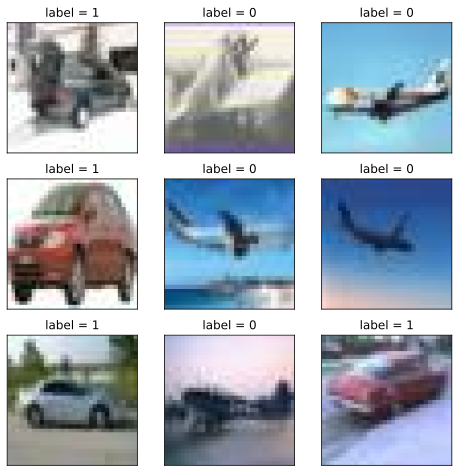

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#Checking part of the samples
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i,(img,label) in enumerate(ds_train.unbatch().take(9)):
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()


In [5]:
for x,y in ds_train.take(1):
    print(x.shape,y.shape)

(100, 32, 32, 3) (100,)


2023-05-05 09:57:51.278794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10000]
	 [[{{node Placeholder/_0}}]]
2023-05-05 09:57:51.279036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10000]
	 [[{{node Placeholder/_0}}]]


2. Model Definition

In [6]:
tf.keras.backend.clear_session() #Clearing the session

inputs = layers.Input(shape=(32,32,3))
x = layers.Conv2D(32,kernel_size=(3,3))(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64,kernel_size=(5,5))(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(rate=0.1)(x)
x = layers.Flatten()(x)
x = layers.Dense(32,activation='relu')(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

model = models.Model(inputs = inputs,outputs = outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 5, 64)          0     

3. Model Training

In [7]:
import datetime
import os

stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join('data', 'autograph', stamp)

## We recommend using pathlib under Python3
# from pathlib import Path
# stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = str(Path('../data/autograph/' + stamp))

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.binary_crossentropy,
        metrics=["accuracy"]
    )

history = model.fit(ds_train,epochs= 10,validation_data=ds_test,
                    callbacks = [tensorboard_callback],workers = 4)


Epoch 1/10


2023-05-05 09:57:51.462881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10000]
	 [[{{node Placeholder/_0}}]]
2023-05-05 09:57:51.463109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10000]
	 [[{{node Placeholder/_0}}]]
2023-05-05 09:57:51.991607: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-05 09:57:54.192301: I tensorflow/compiler

 99/100 [============================>.] - ETA: 0s - loss: 0.4280 - accuracy: 0.7996

2023-05-05 09:57:59.255797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-05-05 09:57:59.256033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 8s 13ms/step - loss: 0.4264 - accuracy: 0.8008 - val_loss: 0.3190 - val_accuracy: 0.8600
Epoch 2/10
100/100 [==============================] - 1s 8ms/step - loss: 0.3158 - accuracy: 0.8599 - val_loss: 0.2744 - val_accuracy: 0.8820
Epoch 3/10
100/100 [==============================] - 1s 8ms/step - loss: 0.2591 - accuracy: 0.8916 - val_loss: 0.2186 - val_accuracy: 0.9130
Epoch 4/10
100/100 [==============================] - 1s 8ms/step - loss: 0.2180 - accuracy: 0.9098 - val_loss: 0.1953 - val_accuracy: 0.9185
Epoch 5/10
100/100 [==============================] - 1s 8ms/step - loss: 0.1906 - accuracy: 0.9251 - val_loss: 0.1844 - val_accuracy: 0.9350
Epoch 6/10
100/100 [==============================] - 1s 8ms/step - loss: 0.1681 - accuracy: 0.9329 - val_loss: 0.1914 - val_accuracy: 0.9270
Epoch 7/10
100/100 [==============================] - 1s 7ms/step - loss: 0.1490 - accuracy: 0.9408 - val_loss: 0.1714 - val_accuracy: 0.9340
Epoch 8/10
100/1

4. Model Evaluation

In [8]:
%load_ext tensorboard
%tensorboard --logdir ./data/keras_model

Reusing TensorBoard on port 6006 (pid 6185), started 16:20:22 ago. (Use '!kill 6185' to kill it.)

In [9]:
from tensorboard import notebook
notebook.list() 

Known TensorBoard instances:
  - port 6006: logdir ./data/keras_model (started 16:20:22 ago; pid 6185)


In [10]:
#Checking model in tensorboard
notebook.start("--logdir ./data/keras_model")

Reusing TensorBoard on port 6006 (pid 6185), started 16:20:22 ago. (Use '!kill 6185' to kill it.)

In [11]:
import pandas as pd 
dfhistory = pd.DataFrame(history.history)
dfhistory.index = range(1,len(dfhistory) + 1)
dfhistory.index.name = 'epoch'

dfhistory

,loss,accuracy,val_loss,val_accuracy
epoch,,,,
1,0.426418,0.8008,0.318958,0.8600
2,0.315839,0.8599,0.274384,0.8820
3,0.259136,0.8916,0.218623,0.9130
4,0.217983,0.9098,0.195314,0.9185
5,0.190641,0.9251,0.184368,0.9350
6,0.168110,0.9329,0.191387,0.9270
7,0.149009,0.9408,0.171363,0.9340
8,0.124246,0.9555,0.156331,0.9365
9,0.113753,0.9556,0.208829,0.9200


2. Model Definition

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

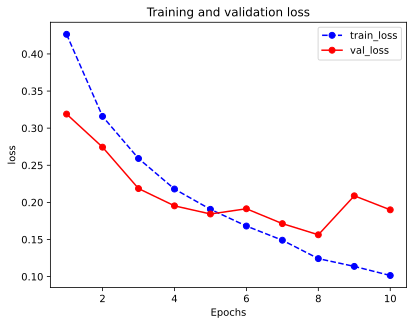

In [13]:
plot_metric(history,"loss")

In [15]:
#Evaluating data using model.evaluate function
val_loss,val_accuracy = model.evaluate(ds_test,workers=4)
print(val_loss,val_accuracy)

20/20 [==============================] - 0s 13ms/step - loss: 0.1900 - accuracy: 0.9240
0.18997125327587128 0.9240000247955322


5. Model Application

In [16]:
model.predict(ds_test)

20/20 [==============================] - 0s 12ms/step


array([[2.0431955e-03],
       [9.7516942e-01],
       [5.6120516e-06],
       ...,
       [2.8060077e-04],
       [9.3103474e-01],
       [1.0592409e-03]], dtype=float32)

In [18]:
for x,y in ds_test.take(1):
    print(model.predict_on_batch(x[0:20]))

[[1.3351140e-03]
 [4.2834217e-03]
 [6.5676111e-04]
 [9.9831688e-01]
 [9.9881387e-01]
 [5.4693568e-01]
 [1.1278790e-03]
 [9.9466091e-01]
 [2.9749095e-03]
 [9.8580867e-01]
 [6.3122131e-02]
 [2.7762660e-05]
 [9.8357773e-01]
 [5.2700907e-01]
 [9.9741995e-01]
 [8.9738870e-01]
 [9.7516543e-01]
 [9.9797648e-01]
 [9.8737854e-01]
 [1.2456060e-06]]


2023-05-05 10:53:14.632045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-05-05 10:53:14.632273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-05-05 10:53:14.655439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [20,32

6. Model Saving

In [20]:
# Saving the weights, this way only save the tensors of the weights
model.save_weights('./data/tf_model_weights.ckpt',save_format = "tf")

In [22]:
# Saving model structure and parameters to a file, so the model allows cross-platform deployment

model.save('./data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

model_loaded = tf.keras.models.load_model('./data/tf_model_savedmodel')
model_loaded.evaluate(ds_test)

2023-05-05 12:31:19.353383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,5,5,64]
	 [[{{node inputs}}]]
2023-05-05 12:31:19.547785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,5,5,64]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./data/tf_model_savedmodel/assets


INFO:tensorflow:Assets written to: ./data/tf_model_savedmodel/assets


export saved model.
20/20 [==============================] - 0s 18ms/step - loss: 0.1900 - accuracy: 0.9240


[0.18997125327587128, 0.9240000247955322]